In [5]:
import pandas as pd
import numpy as np
import javalang
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("processed_code_solutions/all_code_data.csv")
file_data = pd.read_csv("processed_code_solutions/files_code_data.csv")

Feature engineering directly from the code and from the AST tree representation of the code via javalang:

In [7]:
def extract_features(data, file_data):
    data = data.copy()
    file_data = file_data.copy()

    data["num_chars"] = data["code"].str.len()
    data["num_lines"] = data["code"].apply(lambda row: len(row.splitlines()))
    data["avg_line_length"] = data["code"].apply(lambda row: np.mean([len(line) for line in row.splitlines() if len(line)>0]))
    data["max_line_length"] = data["code"].apply(lambda row: max([len(line) for line in row.splitlines() if len(line)>0]))
    data["num_scaled_comments"] = (data["code"].str.count("//") + data["code"].str.count("/\*")) / data["num_lines"]
    data["num_scaled_if"] = data["code"].str.count("if") / data["num_lines"]
    data["num_scaled_for"] = data["code"].str.count("for") / data["num_lines"]
    data["num_scaled_switch"] = data["code"].str.count("switch") / data["num_lines"]
    data["num_scaled_digits"] = (data["code"].apply(lambda row: len([value for value in row if value.isdigit()]))) / data["num_lines"]
    data["num_scaled_exceptions"] = data["code"].str.count("throw new") / data["num_lines"]
    data["num_scaled_empty_lines"] = data["code"].str.count("\n\n") / data["num_lines"]
    data["num_scaled_prints"] = data["code"].str.count("print") / data["num_lines"]

    file_data["num_method_declarations"] = file_data["code"].apply(lambda row: len([node.name for path, node in javalang.parse.parse(row).filter(javalang.tree.MethodDeclaration)]))
    file_data["num_declared_fields"] = file_data["code"].apply(lambda row: len([declarator.name for path, node in javalang.parse.parse(row).filter(javalang.tree.FieldDeclaration) for declarator in node.declarators]))
    file_data["num_local_variables"] = file_data["code"].apply(lambda row: len([declarator.name for path, node in javalang.parse.parse(row).filter(javalang.tree.LocalVariableDeclaration) for declarator in node.declarators]))
    file_data["num_classes"] = file_data["code"].apply(lambda row: len([node.name for path, node in javalang.parse.parse(row).filter(javalang.tree.ClassDeclaration)]))
    file_data["num_field_references"] = file_data["code"].apply(lambda row: len([node.member for path, node in javalang.parse.parse(row).filter(javalang.tree.MemberReference)]))
    file_data["num_method_invocations"] = file_data["code"].apply(lambda row: len([node.member for path, node in javalang.parse.parse(row).filter(javalang.tree.MethodInvocation)]))
    file_data["num_imports"] = file_data["code"].apply(lambda row: len([node.path for path, node in javalang.parse.parse(row).filter(javalang.tree.Import)]))
    file_data["used_field_types"] = (file_data["code"].apply(lambda row: [node.type.name for path, node in javalang.parse.parse(row).filter(javalang.tree.FieldDeclaration)]) 
                                     + file_data["code"].apply(lambda row: [node.type.name for path, node in javalang.parse.parse(row).filter(javalang.tree.LocalVariableDeclaration)])).apply(set)
    for data_type in ["boolean", "List", "Integer", "Point", "ArrayList", "StringBuilder"]:
        file_data[f"used_{data_type}"] = file_data["used_field_types"].apply(lambda row: data_type in row)
    file_data["variable_names"] = file_data["code"].apply(lambda row: list({node.member for path, node in javalang.parse.parse(row).filter(javalang.tree.MemberReference)}))
    
    variable_names = file_data.groupby(["name", "source", "style", "version"], dropna=False)["variable_names"].sum().reset_index()
    variable_names["avg_name_length"] = variable_names["variable_names"].apply(lambda row: np.mean([len(value) for value in row]))
    variable_names["max_name_length"] = variable_names["variable_names"].apply(lambda row: np.max([len(value) for value in row]))
    variable_names.drop("variable_names", axis=1, inplace=True)
    file_data.drop("variable_names", axis=1, inplace=True)
    file_data["all_comments"] = file_data["code"].apply(lambda row: [comment for comment in [line.strip() for comment in re.findall('/\*.*?\*/', row, re.DOTALL) for line in comment.splitlines()] if comment != "/*" and comment != "*/"]\
                                                      + [comment[2:].strip() for comment in re.findall('//.*', row)])
    variable_names = variable_names.merge(file_data.groupby(["name", "source", "style", "version"], dropna=False)["all_comments"].sum().reset_index(), on = ["name", "source", "style", "version"])
    variable_names["avg_comment_length"] = variable_names["all_comments"].apply(lambda row: 0 if len(row) == 0 else np.mean([len(value) for value in row]))
    variable_names["max_comment_length"] = variable_names["all_comments"].apply(lambda row: 0 if len(row) == 0 else np.max([len(value) for value in row]))
    variable_names.drop("all_comments", axis=1, inplace=True)
    file_data.drop("all_comments", axis=1, inplace=True)

    file_data["num_files"] = 1

    grouped_file_data = file_data.groupby(["name", "source", "style", "version"], dropna=False).sum().reset_index()
    for data_type in ["boolean", "List", "Integer", "Point", "ArrayList", "StringBuilder"]:
        grouped_file_data[f"used_{data_type}"] = grouped_file_data[f"used_{data_type}"].astype(bool)
    
    grouped_file_data = grouped_file_data.merge(data[["name", "source", "style", "version", "num_lines"]], on=["name", "source", "style", "version"])
    grouped_file_data_columns = [column for column in grouped_file_data.columns if column[:3]=="num" and column != "num_files"]

    for column in grouped_file_data_columns:
        grouped_file_data[f"num_scaled_{column[4:]}"] = grouped_file_data[column] / grouped_file_data["num_lines"]
        grouped_file_data.drop(column, axis=1, inplace=True)

    data = data.merge(grouped_file_data.drop("num_scaled_lines", axis=1), on=["name", "source", "style", "version"])
    data = data.merge(variable_names, on=["name", "source", "style", "version"])
    
    return data

In [8]:
features_data = extract_features(data, file_data)

In [9]:
features_data.columns

Index(['name', 'source', 'style', 'version', 'code', 'num_chars', 'num_lines',
       'avg_line_length', 'max_line_length', 'num_scaled_comments',
       'num_scaled_if', 'num_scaled_for', 'num_scaled_switch',
       'num_scaled_digits', 'num_scaled_exceptions', 'num_scaled_empty_lines',
       'num_scaled_prints', 'used_boolean', 'used_List', 'used_Integer',
       'used_Point', 'used_ArrayList', 'used_StringBuilder', 'num_files',
       'num_scaled_method_declarations', 'num_scaled_declared_fields',
       'num_scaled_local_variables', 'num_scaled_classes',
       'num_scaled_field_references', 'num_scaled_method_invocations',
       'num_scaled_imports', 'avg_name_length', 'max_name_length',
       'avg_comment_length', 'max_comment_length'],
      dtype='object')

In [11]:
len(features_data.columns)

35

In [12]:
features_data.to_csv("processed_code_solutions/feature_data.csv", index=False)

If the features are not scaled, then they simply reflect the length of the code (see correlation matrix below) - e.g. longer code naturally has more field references, etc. 
By dividing each feature by the length of the code, we can extract whether a relatively large or small number of e.g. field references have been included.

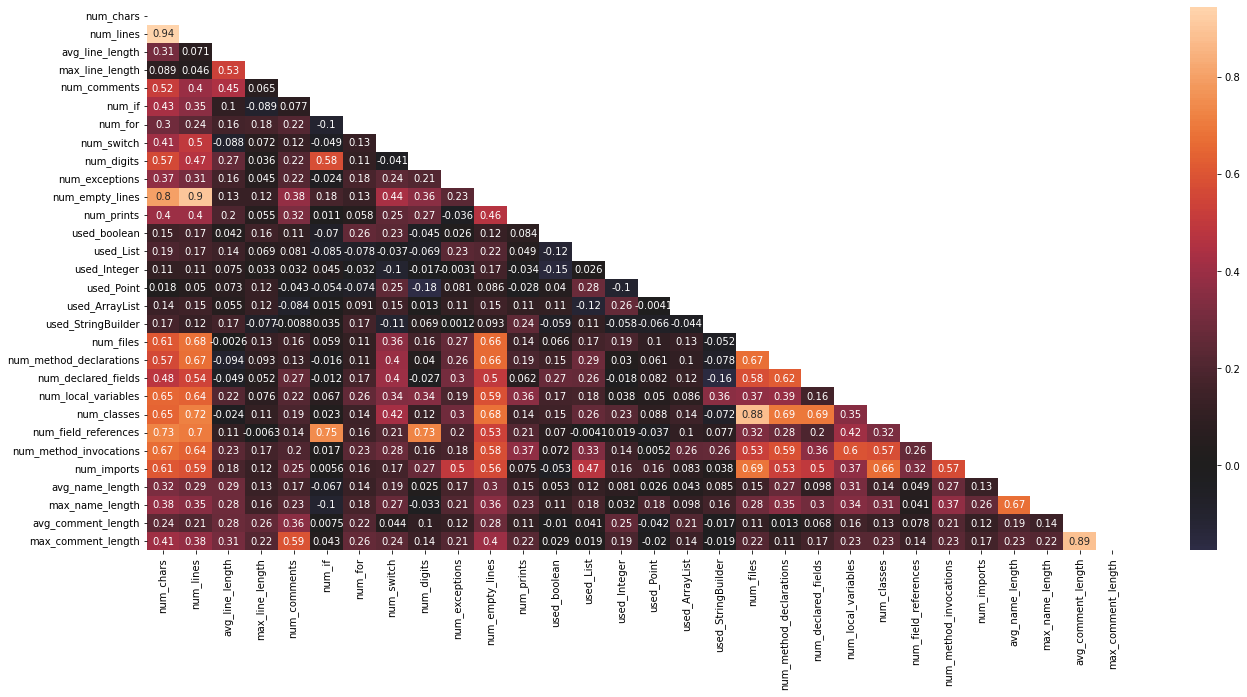

In [13]:
non_scaled_data = features_data.copy()
scaled_columns = [column for column in features_data.columns if "scaled" in column]
for column in scaled_columns:
    non_scaled_data[column] = non_scaled_data[column] * non_scaled_data["num_lines"]

non_scaled_data.columns = list(pd.Series(non_scaled_data.columns).str.replace("_scaled", ""))
plt.subplots(figsize=(22, 10))
sns.heatmap(non_scaled_data.corr(), center=0, annot=True, mask=np.triu(np.ones_like(features_data.corr(), dtype=bool)));